# Dataset Exploration Notebook

Let's set up things for Colab and non-Colab (just in case...)

In [1]:
import os
import sys

if colab := 'google_colab' in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    # in case we'll do a shared drive, this will have to be changed.
    # For now it is basically a placeholder
    BASE_PATH = "drive/MyDrive/HLT/ProjectAthena/"
    sys.path.insert(0,BASE_PATH)

    !pip install wordcloud
    !pip install -U scikit-learn
else:
    BASE_PATH = ".."

In [2]:
# More imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Dict, Optional

In [3]:
df = pd.read_csv(os.path.join(BASE_PATH,'philosophy_data.csv'))
df.head()

title author school  \
0  Plato - Complete Works  Plato  plato   
1  Plato - Complete Works  Plato  plato   
2  Plato - Complete Works  Plato  plato   
3  Plato - Complete Works  Plato  plato   
4  Plato - Complete Works  Plato  plato   

                                      sentence_spacy  \
0   What's new, Socrates, to make you leave your ...   
1  Surely you are not prosecuting anyone before t...   
2  The Athenians do not call this a prosecution b...   
3                              What is this you say?   
4  Someone must have indicted you, for you are no...   

                                        sentence_str  \
0   What's new, Socrates, to make you leave your ...   
1  Surely you are not prosecuting anyone before t...   
2  The Athenians do not call this a prosecution b...   
3                              What is this you say?   
4  Someone must have indicted you, for you are no...   

   original_publication_date  corpus_edition_date  sentence_length  \
0                       -350                 1997              125   
1                       -350                 1997               69   
2                       -350                 1997               74   
3                       -350                 1997               21   
4                       -350                 1997              101   

                                    sentence_lowered  \
0   what's new, socrates, to make you leave your ...   
1  surely you are not prosecuting anyone before t...   
2  the athenians do not call this a prosecution b...   
3                              what is this you say?   
4  someone must have indicted you, for you are no...   

                                       tokenized_txt  \
0  ['what', 'new', 'socrates', 'to', 'make', 'you...   
1  ['surely', 'you', 'are', 'not', 'prosecuting',...   
2  ['the', 'athenians', 'do', 'not', 'call', 'thi...   
3               ['what', 'is', 'this', 'you', 'say']   
4  ['someone', 'must', 'have', 'indicted', 'you',...   

                                      lemmatized_str  
0     what be new , Socrates , to make -PRON- lea...  
1   surely -PRON- be not prosecute anyone before ...  
2   the Athenians do not call this a prosecution ...  
3                          what be this -PRON- say ?  
4   someone must have indict -PRON- , for -PRON- ...

## Dataset description: basic metrics

Let's start from the basics: how many texts in this dataset, from how many authors...

In [4]:
print(f'There are {len(df['title'].unique())} texts from {len(df['author'].unique())} authors, spanning {len(df['school'].unique())} schools of thought')

There are 59 texts from 36 authors, spanning 13 schools of thought


In [5]:
# Number of texts and authors per school of thought
df.groupby('school')[['title','author']].nunique()


title  author
school                        
analytic            11       7
aristotle            1       1
capitalism           3       3
communism            3       2
continental          6       3
empiricism           6       3
feminism             3       3
german_idealism      7       3
nietzsche            5       1
phenomenology        5       3
plato                1       1
rationalism          6       4
stoicism             2       2

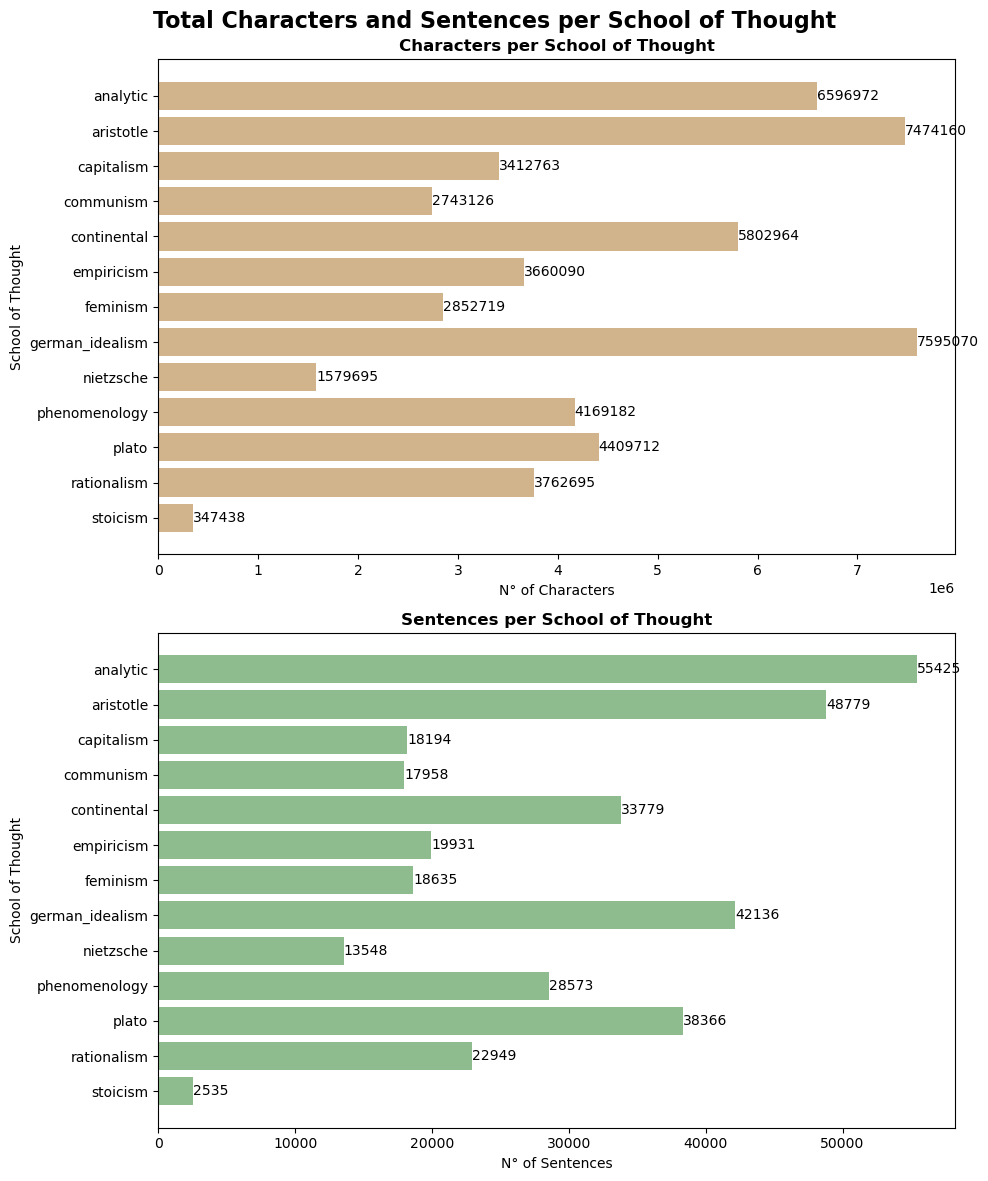

In [7]:
# Total amount of characters per school of thought
chars_per_school = df.groupby('school')['sentence_length'].sum().sort_index(ascending=False)
sentences_per_school = df['school'].value_counts().sort_index(ascending=False)

# Plotting the total amount of characters and sentences per school of thought
fig, ax = plt.subplots(2, figsize=(10, 12))
fig.suptitle('Total Characters and Sentences per School of Thought', fontweight='bold', fontsize=16)

# Plot for characters
barsC = ax[0].barh(chars_per_school.index, chars_per_school.values, color='tan')
ax[0].bar_label(barsC, fmt='%.0f')
ax[0].set_title('Characters per School of Thought',fontweight='bold')
ax[0].set_xlabel('N° of Characters')
ax[0].set_ylabel('School of Thought')

# Plot for sentences
barsS = ax[1].barh(sentences_per_school.index, sentences_per_school.values, color='darkseagreen')
ax[1].bar_label(barsS, fmt='%.0f')
ax[1].set_title('Sentences per School of Thought',fontweight='bold')
ax[1].set_xlabel('N° of Sentences')
ax[1].set_ylabel('School of Thought')

plt.tight_layout()
plt.show()

From these numbers we can already draw some considerations:
- The classes are very imbalanced (in terms of sentences, i.e. items to classify). The most populated classes are those relative to analytic philosophy, Aristotle, german idealism, plato
- The classes with the most sentences are not always those with the most number of characters. This leads to another interesting aspect of the analysis, which is *sentence length*

### Sentence length etc.

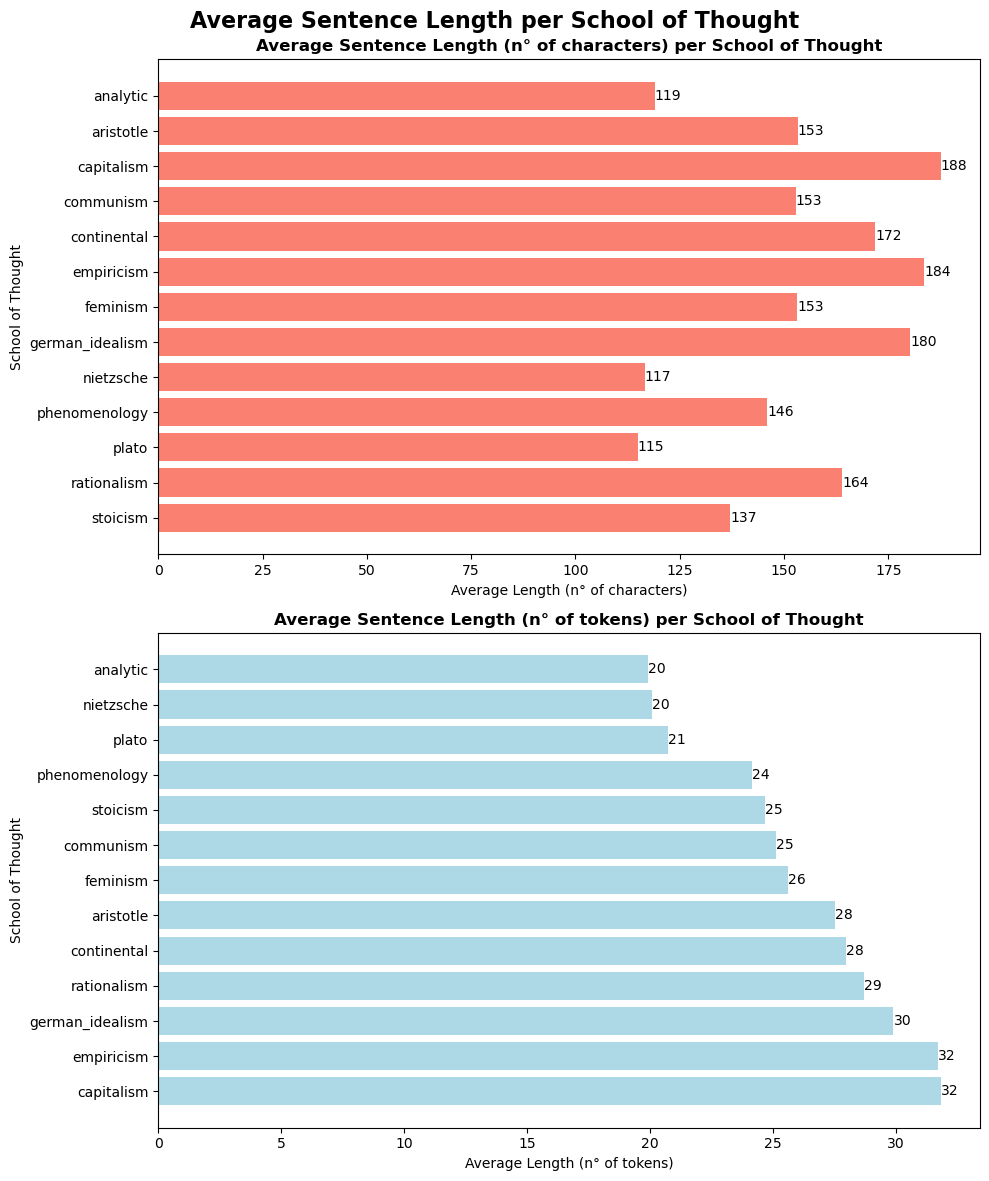

In [8]:
# all this mess because .csv saves lists as strings
sentence_l_df = df[['school','tokenized_txt']].copy()
sentence_l_df['tokenized_txt'] = sentence_l_df['tokenized_txt'].apply(lambda s: len([subs[1:-1] for subs in s[1:-1].split(', ')]))
sentence_l_df.groupby('school')['tokenized_txt'].mean().sort_values(ascending=False)

# Average sentence length per school of thought
fig, ax = plt.subplots(2, figsize=(10, 12))
fig.suptitle('Average Sentence Length per School of Thought', fontweight='bold', fontsize=16)

# Plot for characters
barsC = ax[0].barh(chars_per_school.index, chars_per_school.values / sentences_per_school.values, color='salmon')
ax[0].bar_label(barsC, fmt='%.0f')
ax[0].set_xlabel('Average Length (n° of characters)')
ax[0].set_ylabel('School of Thought')
ax[0].set_title('Average Sentence Length (n° of characters) per School of Thought', fontweight='bold')

# Plot for tokens
barsS = ax[1].barh(sentence_l_df.groupby('school')['tokenized_txt'].mean().sort_values(ascending=False).index, sentence_l_df.groupby('school')['tokenized_txt'].mean().sort_values(ascending=False).values, color='lightblue')
ax[1].bar_label(barsS, fmt='%.0f')
ax[1].set_xlabel('Average Length (n° of tokens)')
ax[1].set_ylabel('School of Thought')
ax[1].set_title('Average Sentence Length (n° of tokens) per School of Thought', fontweight='bold')


plt.tight_layout()
plt.show()

Of course how long a sentence is in terms of number of characters doesn't tell much (maybe the german philosopher use those lengthy german words). The analysis should instead focus on the number of words/tokens in the sentence.

In [9]:
longest = df.loc[sentence_l_df['tokenized_txt'].idxmax()]

print(f'Sentence of maximal length: "{longest['sentence_spacy']}"')
print(f"From {longest['title']}, by {longest['author']} ({longest['school']})")
print(f"Length: {sentence_l_df['tokenized_txt'].max()} tokens")

Sentence of maximal length: "We have seen on what foundations this aggregate operated: a whole field of immanence that is reproduced on an always larger scale, that is continually multiplying its axioms to suit its needs, that is filled with images and with images of images, through which desire is determined to desire its own repression (imperialism); an unprecedented decoding and deterritorialization, which institutes a combination as a system of differential relations between the decoded and deterritorialized flows, in such a way that social inscription and repression no longer even need to bear directly upon bodies and persons, but on the contrary precede them (axiomatic: regulation and application); a surplus value determined as a surplus value of flux, whose extortion is not brought about by a simple arithmetical difference between two quantities that are homogeneous and belong to the same code, but precisely by differential relations between heterogeneous magnitudes that are not

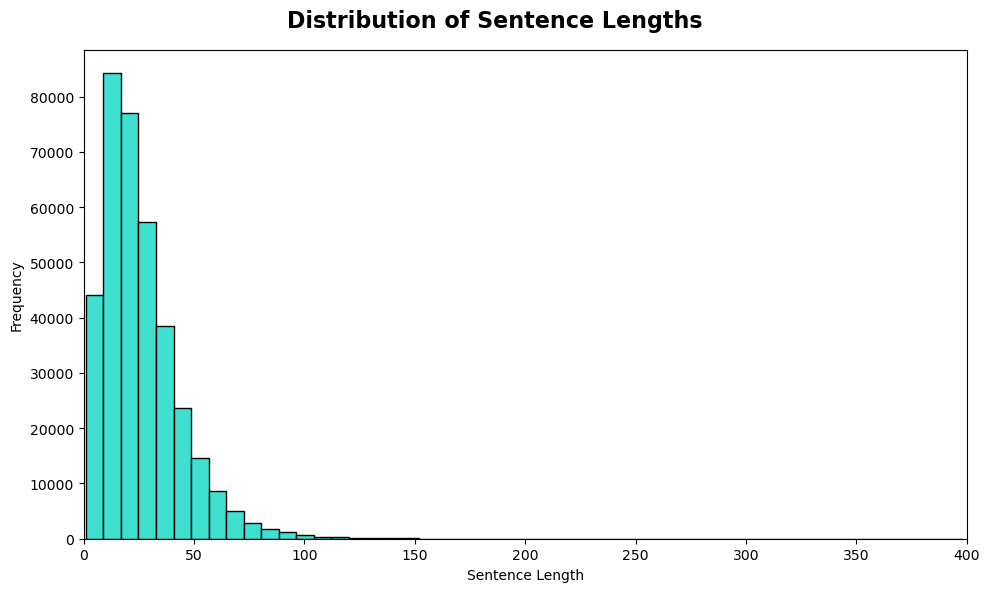

In [10]:
# distribution of sentence lengths
fig, ax = plt.subplots(1, figsize=(10, 6))
fig.suptitle('Distribution of Sentence Lengths', fontweight='bold', fontsize=16)

ax.hist(sentence_l_df['tokenized_txt'], bins=50, color='turquoise', edgecolor='black')
ax.set_xlim(0, 400)
ax.set_xlabel('Sentence Length')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
# Qui vorrei fare una CDF, o qualcosa di simile. Ovvero qualcosa che dice quanta
# massa sta prima di un certo valore.
# Ovvero la percentuale di frasi di lunghezza < x
# Può servire?

### Misc

Let's check if the fields `sentence_str` and `sentence_spacy` contain anything different

In [11]:
def diff_index(str1, str2):
    for i in range(min(len(str1), len(str2))):
        if str1[i] != str2[i]:
            return i
    if len(str1) != len(str2):
        return min(len(str1), len(str2))
    return -1

for i in range(df.shape[0]):
    st, sp = df.iloc[i]['sentence_str'], df.iloc[i]['sentence_spacy']
    if (st != sp):
        print(f"1st difference in row {i} of the dataframe")
        print(f'sentence_str: "{st}"')
        print(f'sentence_spacy: "{sp}"')
        print(f"They differ at index {diff_index(st,sp)}")
        break

if i == df.shape[0]-1:
    print("No difference between sentence_str and sentence_spacy, it seems")

No difference between sentence_str and sentence_spacy, it seems


---

## Dataset description: words distribution

Now that we've seen some simple numbers, it's time to study the distribution of words in the various texts.

### Schools dictionaries, BOW

Let's try to create bag of words, using scikit-learn. We use the standard English stopwords list provided by scikit-learn, for now. We'll see later how to deal with it

In [12]:
# Here put stopwords!!
stopwords_list = []

In [13]:
from utils import create_bow

# we try with plato
bow_plato = create_bow(school='plato', dataframe = df)
len(bow_plato)

18628

Working with the dataframe is a pain in the ass. Let me define a structure that contains the data I want to process in the next subsection.

### Wordclouds

I start with wordcloud. Then we think about numbers. And stopwords

In [19]:
from utils import make_wordcloud, create_bigstring


Here is where another decision must be taken. Which stopwords to consider? This choice should:
- be coherent across models
- be coherent with the choice of the bag of words, above

In [15]:
# List of custom stopwords taken from the original project (not yet)
custom_stopwords = ['–', 'also', 'something', 'cf', 'thus', 'two', 'now', 'would', 'make', 'eb', 'u', 'well', 'even', 'said', 'eg', 'us',
                    'n', 'sein', 'e', 'da', 'therefore', 'however', 'would', 'thing', 'must', 'merely', 'way', 'since', 'latter', 'first',
                    'B', 'mean', 'upon', 'yet', 'cannot', 'c', 'C', 'let', 'may', 'might', "'s", 'b', 'ofthe', 'p.', '_', '-', 'eg', 'e.g.',
                    'ie', 'i.e.', 'f', 'l', "n't", 'e.g', 'i.e', '—', '--', 'hyl', 'phil', 'one', 'press', 'cent', 'pl'] + stopwords_list



In [17]:
schools = df['school'].unique()

bigstrings_dict = {}
clouds_dict = {}
for school in schools:
    # create a big string concatenating all sentences of a given school...
    bigstrings_dict[school] = create_bigstring(school, dataframe=df)
    # ... and then we create the wordcloud
    clouds_dict[school] = make_wordcloud(bigstrings_dict[school], stopwords=custom_stopwords)

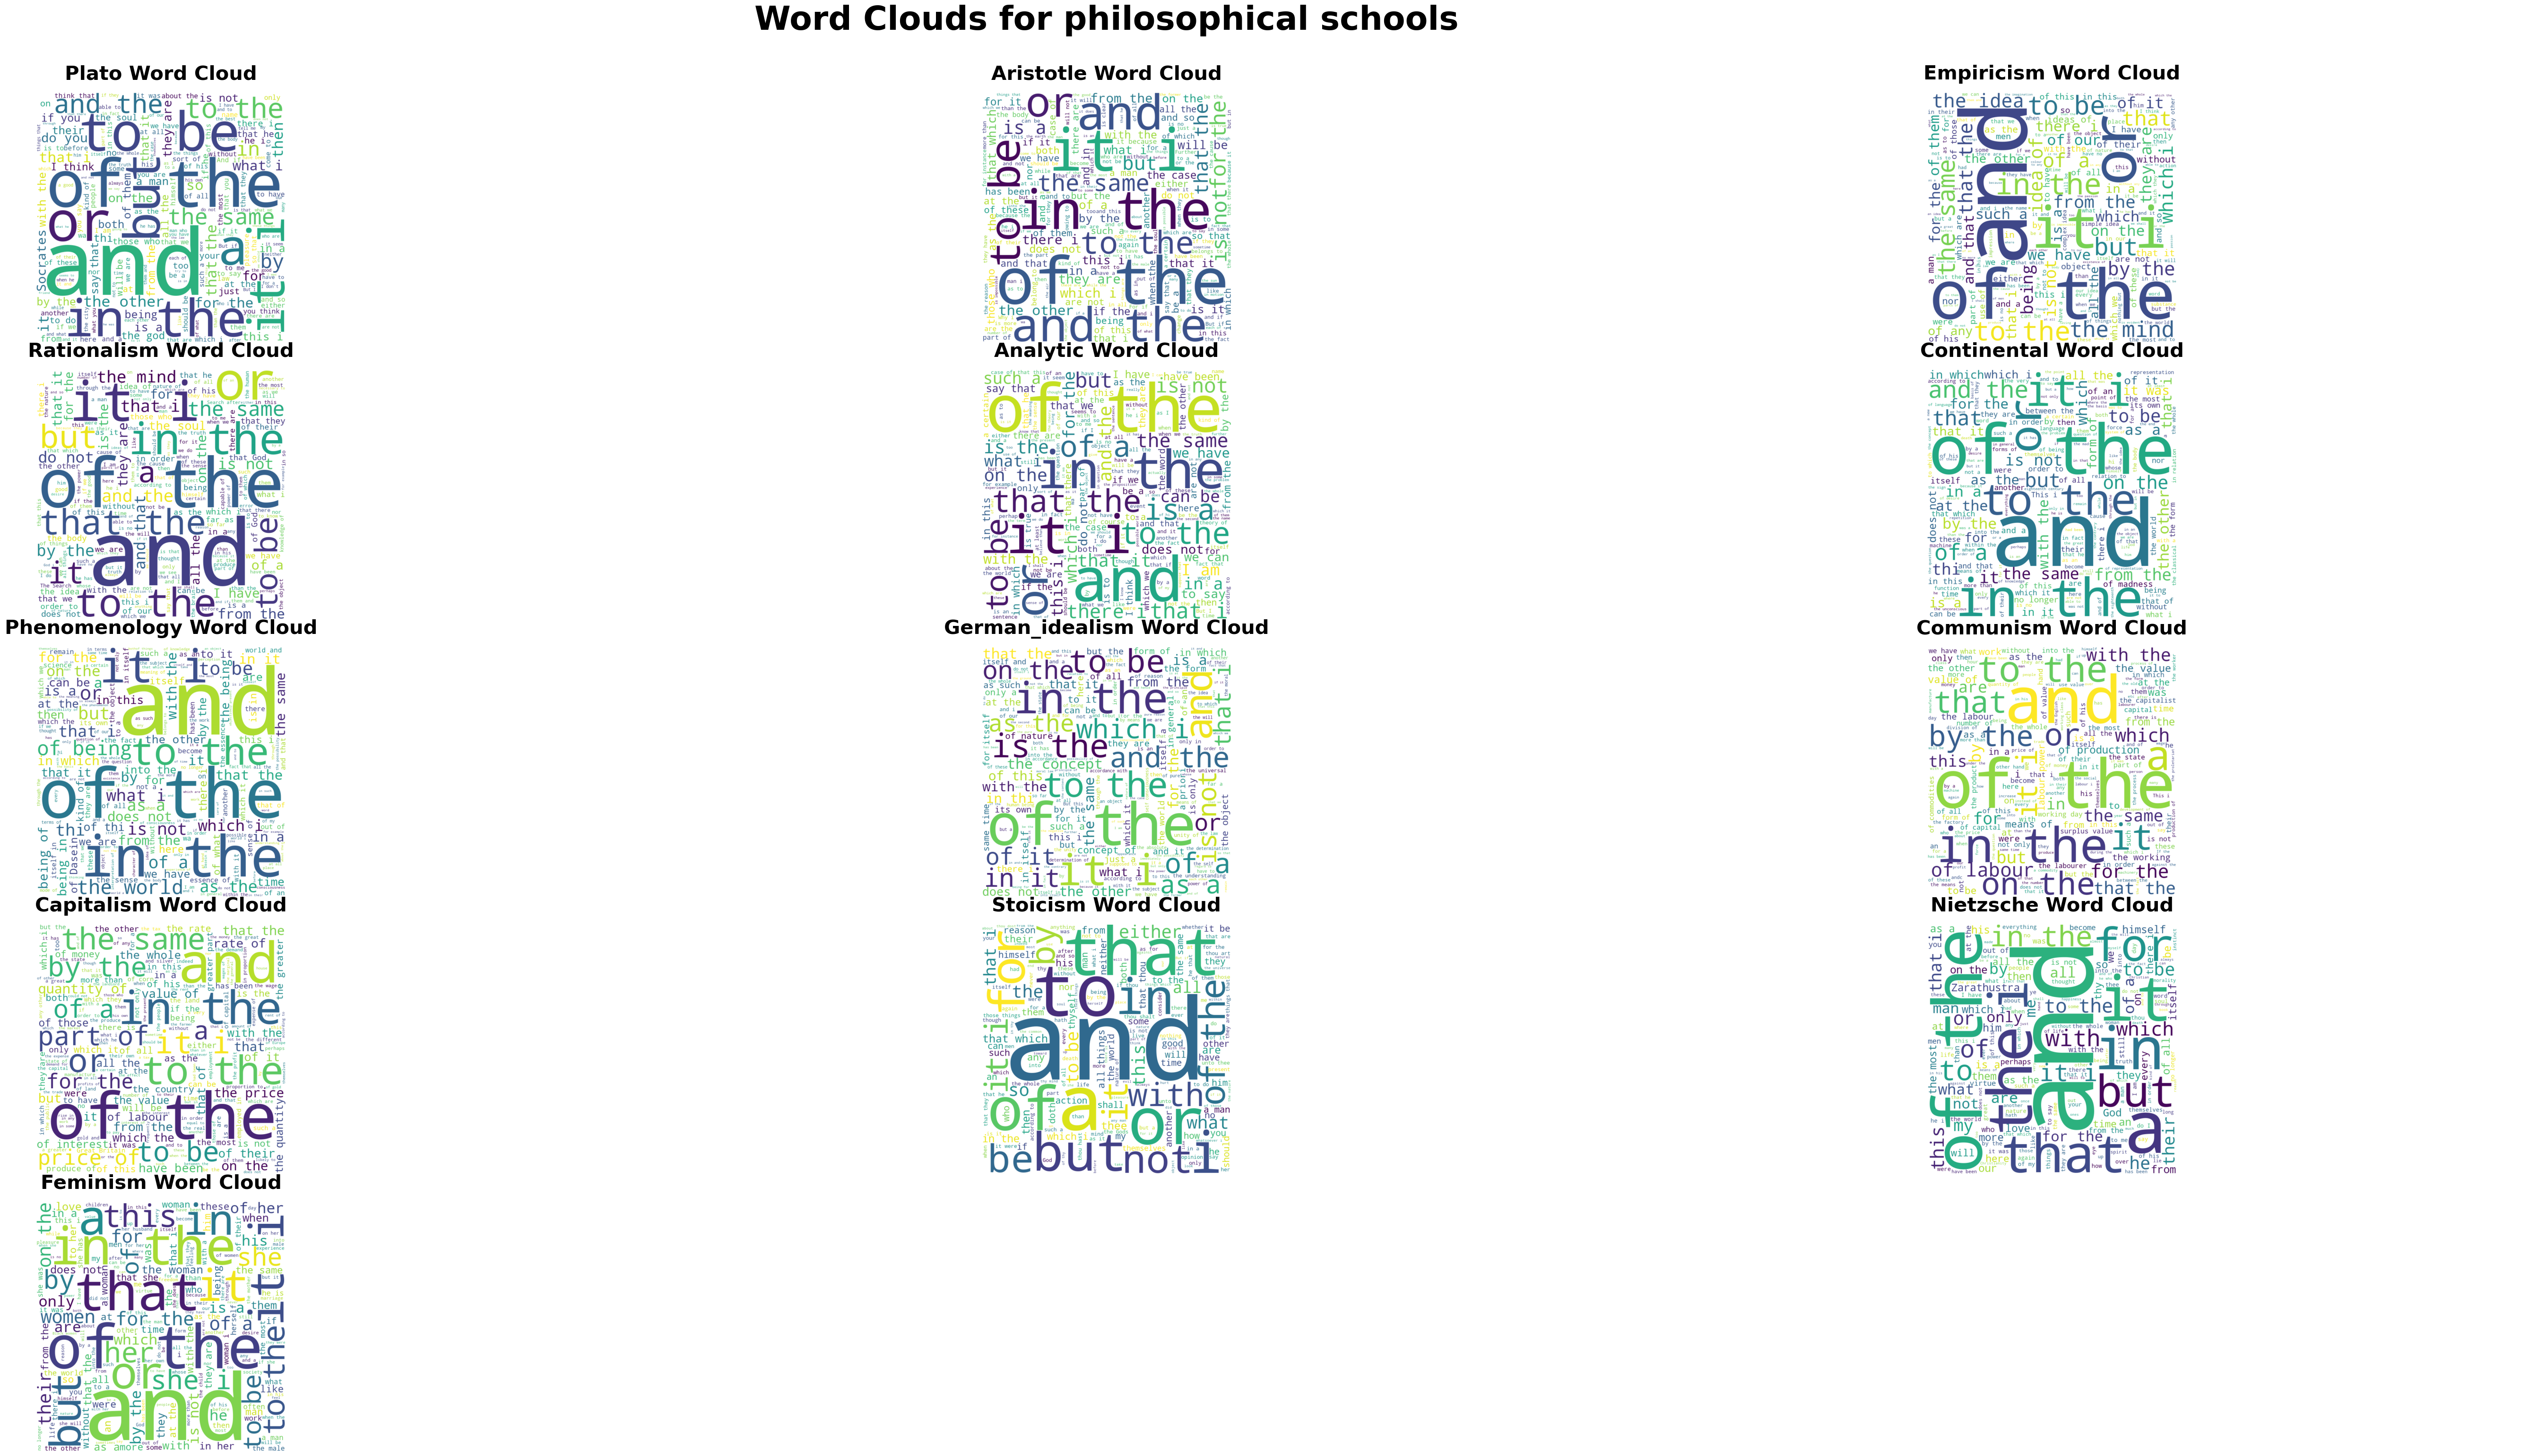

In [18]:
# TODO: Still a bit ugly!!

schools = df['school'].unique()

# Create a figure for the subplots
fig, axs = plt.subplots(5, 3, figsize=(60, 30)) 
axs = axs.ravel()       # flatten axs indices for easier iteration

# Iterate over the schools
for i, school in enumerate(schools):
    
    wc = clouds_dict[school]

    # Display the word cloud in a subplot
    axs[i].imshow(wc, interpolation="bilinear")
    axs[i].set_title(f'{school.capitalize()} Word Cloud', fontsize=30, pad=20, fontweight='bold')  # Set title to the school name
    axs[i].axis('off')

# Add a title for the whole plot
plt.suptitle('Word Clouds for philosophical schools', fontsize=50, y=1.02, fontweight='bold')

# Hide unused subplots
for i in range(len(schools), 15):
    axs[i].axis('off')

plt.tight_layout(pad=0)
plt.show()